# [**Arbres de décision AdaBoosted multi-classe**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/1_11_ensembles/plot_adaboost_multiclass.ipynb)<br/>([_Multi-class AdaBoosted Decision Trees_](https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_multiclass.html))

Cet exemple montre comment l'amplification peut améliorer la précision des prédictions dans un problème de classification multi-étiquettes. Il reproduit une expérience similaire à celle représentée dans la Figure 1 de Zhu et al [1].

Le principe fondamental d'AdaBoost (Adaptive Boosting) est de s'adapter à une séquence de modèles faibles (par exemple, des arbres de décision) sur des versions ré-échantillonnées à plusieurs reprises des données. Chaque échantillon est associé à un poids qui est ajusté après chaque étape d'entraînement, de sorte que les échantillons mal classés se voient attribuer des poids plus élevés. Le processus de ré-échantillonnage avec remplacement prend en compte les poids attribués à chaque échantillon. Les échantillons ayant des poids plus élevés ont plus de chances d'être sélectionnés plusieurs fois dans le nouvel ensemble de données, tandis que les échantillons ayant des poids plus faibles sont moins susceptibles d'être sélectionnés. Cela garantit que les itérations ultérieures de l'algorithme se concentrent sur les échantillons difficiles à classer.

#### Références

🔬 [1] (1,2) J Zhu, H. Zou, S. Rosset, T. Hastie, [**“Multi-class AdaBoost”**](https://www.intlpress.com/site/pub/files/_fulltext/journals/sii/2009/0002/0003/SII-2009-0002-0003-a008.pdf), Statistics and Its Interface, 2009.

In [ ]:
# Noel Dawe <noel.dawe@gmail.com>
# License: BSD 3 clause

# Création de l'ensemble de données

L'ensemble de données de classification est construit en utilisant une distribution normale standard à dix dimensions ($x \in \R^{10}$) et en définissant trois classes séparées par des sphères concentriques à dix dimensions emboîtées, de sorte que le nombre d'échantillons dans chaque classe soit à peu près égal (quantiles de la distribution $\chi^2$).

In [1]:
from sklearn.datasets import make_gaussian_quantiles

X, y = make_gaussian_quantiles(
    n_samples=2_000, n_features=10, n_classes=3, random_state=1
)

Nous divisons l'ensemble de données en 2 ensembles : 70 % des échantillons sont utilisés pour l'entraînement et les 30 % restants pour les tests.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=42
)

# Entraînement de l'`AdaBoostClassifier`

Nous entraînons l'[**`AdaBoostClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier). L'estimateur utilise le renforcement pour améliorer la précision de la classification. Le renforcement est une méthode conçue pour entraîner des modèles faibles (c'est-à-dire des `base_estimator`) qui apprennent des erreurs de leurs prédécesseurs.

Ici, nous définissons le modèle faible comme un [**`DecisionTreeClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) et définissons le nombre maximum de feuilles à 8. Dans un cadre réel, ce paramètre devrait être réglé. Nous le fixons à une valeur plutôt faible pour limiter la durée d'exécution de l'exemple.

L'algorithme `SAMME` intégré dans l'[**`AdaBoostClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) utilise ensuite les prédictions correctes ou incorrectes faites par le modèle faible actuel pour mettre à jour les poids des échantillons utilisés pour l'entraînement des modèles faibles consécutifs. De plus, le poids du modèle faible lui-même est calculé en fonction de sa précision dans la classification des exemples d'entraînement. Le poids du modèle faible détermine son influence sur la prédiction de l'ensemble final.

In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

weak_learner = DecisionTreeClassifier(max_leaf_nodes=8)
n_estimators = 300

adaboost_clf = AdaBoostClassifier(
    estimator=weak_learner,
    n_estimators=n_estimators,
    algorithm="SAMME",
    random_state=42,
).fit(X_train, y_train)

# Analyse

## Convergence de l'`AdaBoostClassifier`

Pour démontrer l'efficacité du renforcement dans l'amélioration de la précision, nous évaluons l'erreur de mauvaise classification des arbres renforcés par rapport à deux scores de référence. Le premier score de référence est l'erreur de mauvaise classification (`misclassification_error`) obtenue à partir d'un modèle faible unique (c'est-à-dire un [**`DecisionTreeClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)), qui sert de point de référence. Le deuxième score de référence est obtenu à partir du [**`DummyClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier), qui prédit la classe la plus fréquente dans un ensemble de données.

In [4]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_clf = DummyClassifier()


def misclassification_error(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)


weak_learners_misclassification_error = misclassification_error(
    y_test, weak_learner.fit(X_train, y_train).predict(X_test)
)

dummy_classifiers_misclassification_error = misclassification_error(
    y_test, dummy_clf.fit(X_train, y_train).predict(X_test)
)

print(
    "DecisionTreeClassifier's misclassification_error: "
    f"{weak_learners_misclassification_error:.3f}"
)
print(
    "DummyClassifier's misclassification_error: "
    f"{dummy_classifiers_misclassification_error:.3f}"
)

DecisionTreeClassifier's misclassification_error: 0.475
DummyClassifier's misclassification_error: 0.692


Après l'entraînement du modèle [**`DecisionTreeClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier), l'erreur obtenue dépasse la valeur attendue qui aurait été obtenue en devinant l'étiquette de classe la plus fréquente, comme le fait le [**`DummyClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier).

Maintenant, nous calculons la `misclassification_error`, c'est-à-dire `1 - précision`, du modèle additif ([**`DecisionTreeClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)) à chaque itération de renforcement sur l'ensemble de test pour évaluer sa performance.

Nous utilisons [**`staged_predict`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier.staged_predict) qui effectue autant d'itérations que le nombre d'estimateurs ajustés (correspondant à `n_estimators`). À l'itération `n`, les prédictions d'AdaBoost n'utilisent que les `n` premiers modèles faibles. Nous comparons ces prédictions avec les prédictions réelles `y_test` et nous en concluons donc sur l'avantage (ou non) d'ajouter un nouveau modèle faible dans la chaîne.

Nous représentons l'erreur de mauvaise classification pour les différentes étapes :

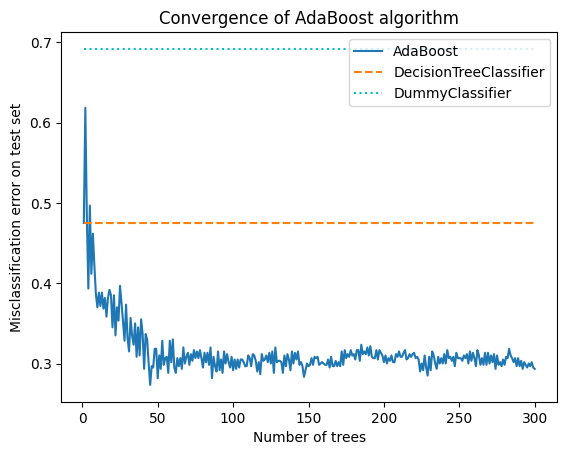

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

boosting_errors = pd.DataFrame(
    {
        "Number of trees": range(1, n_estimators + 1),
        "AdaBoost": [
            misclassification_error(y_test, y_pred)
            for y_pred in adaboost_clf.staged_predict(X_test)
        ],
    }
).set_index("Number of trees")
ax = boosting_errors.plot()
ax.set_ylabel("Misclassification error on test set")
ax.set_title("Convergence of AdaBoost algorithm")

plt.plot(
    [boosting_errors.index.min(), boosting_errors.index.max()],
    [weak_learners_misclassification_error, weak_learners_misclassification_error],
    color="tab:orange",
    linestyle="dashed",
)
plt.plot(
    [boosting_errors.index.min(), boosting_errors.index.max()],
    [
        dummy_classifiers_misclassification_error,
        dummy_classifiers_misclassification_error,
    ],
    color="c",
    linestyle="dotted",
)
plt.legend(["AdaBoost", "DecisionTreeClassifier", "DummyClassifier"], loc=1)
plt.show()

Le graphique montre l'erreur de mauvaise classification sur l'ensemble de test après chaque itération d'amplification. Nous constatons que l'erreur des arbres amplifiés converge vers une erreur d'environ 0,3 après 50 itérations, indiquant une précision nettement supérieure par rapport à un seul arbre, comme illustré par la ligne en pointillés sur le graphique.

L'erreur de mauvaise classification varie en raison de l'utilisation par l'algorithme `SAMME` des sorties discrètes des modèles faibles pour former le modèle amplifié.

La convergence de l'[**`AdaBoostClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) est principalement influencée par le taux d'apprentissage (c'est-à-dire `learning_rate`), le nombre de modèles faibles utilisés (`n_estimators`), et l'expressivité des modèles faibles (par exemple, `max_leaf_nodes`).

## Erreurs et poids des modèles faibles

Comme mentionné précédemment, AdaBoost est un modèle additif progressif. Nous nous concentrons maintenant sur la compréhension de la relation entre les poids attribués aux modèles faibles et leurs performances statistiques.

Nous utilisons les attributs `estimator_errors_` et `estimator_weights_` du [**`AdaBoostClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) ajusté pour examiner ce lien.

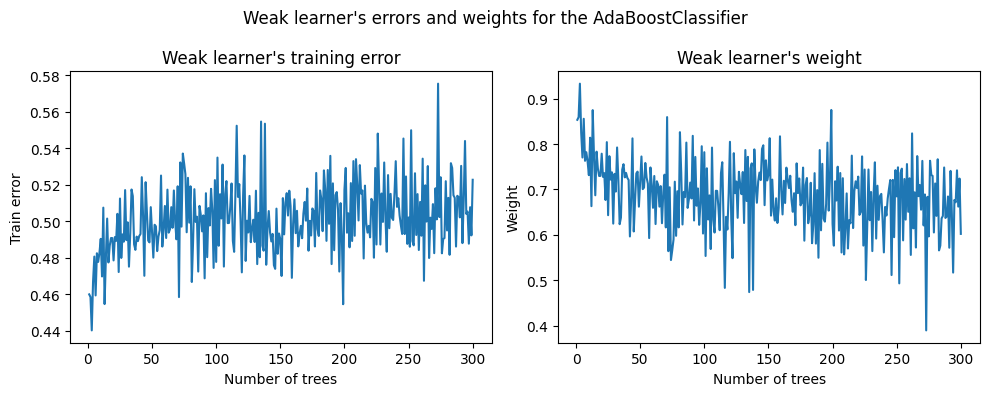

In [6]:
weak_learners_info = pd.DataFrame(
    {
        "Number of trees": range(1, n_estimators + 1),
        "Errors": adaboost_clf.estimator_errors_,
        "Weights": adaboost_clf.estimator_weights_,
    }
).set_index("Number of trees")

axs = weak_learners_info.plot(
    subplots=True, layout=(1, 2), figsize=(10, 4), legend=False, color="tab:blue"
)
axs[0, 0].set_ylabel("Train error")
axs[0, 0].set_title("Weak learner's training error")
axs[0, 1].set_ylabel("Weight")
axs[0, 1].set_title("Weak learner's weight")
fig = axs[0, 0].get_figure()
fig.suptitle("Weak learner's errors and weights for the AdaBoostClassifier")
fig.tight_layout()

Sur le graphique de gauche, nous montrons l'erreur pondérée de chaque modèle faible sur l'ensemble d'entraînement ré-pondéré à chaque itération d'amplification. Sur le graphique de droite, nous montrons les poids associés à chaque modèle faible, qui sont ensuite utilisés pour effectuer les prédictions du modèle additif final.

Nous constatons que l'erreur du modèle faible est l'inverse des poids. Cela signifie que notre modèle additif fera davantage confiance à un modèle faible qui commet de plus petites erreurs (sur l'ensemble d'entraînement), en augmentant son impact sur la décision finale. En effet, il s'agit précisément de la formulation de la mise à jour des poids des estimateurs de base après chaque itération dans AdaBoost.

> **Détails mathématiques :**  
> Le poids associé à un modèle faible entraîné à l'étape $m$ est inversement associé à son erreur de mauvaise classification, de sorte que :
> $$\alpha^{(m)} = \log \frac{1 - \text{err}^{(m)}}{\text{err}^{(m)}} + \log (K - 1),$$
> où $\alpha^{(m)}$ et $\text{err}^{(m)}$ sont respectivement le poids et l'erreur du $m$-ième modèle faible, et $K$ est le nombre de classes dans notre problème de classification.

Une autre observation intéressante tient au fait que les premiers modèles faibles du modèle commettent moins d'erreurs que les modèles faibles ultérieurs de la chaîne d'amplification'.

L'intuition derrière cette observation est la suivante : en raison de la pondération des échantillons, les classifieurs ultérieurs sont contraints d'essayer de classer des échantillons plus difficiles ou bruyants et d'ignorer des échantillons déjà bien classés. Par conséquent, l'erreur globale sur l'ensemble d'entraînement augmentera. C'est pourquoi les poids des modèles faibles sont conçus pour compenser les modèles faibles moins performants.